In [1]:
import os
import json
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Conv1D, BatchNormalization
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.regularizers import l2
import keras_tuner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
from datetime import datetime
from tqdm.notebook import trange, tqdm
from matplotlib.pyplot import figure
from matplotlib.ticker import AutoLocator
from finta import TA

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
data = pd.read_csv('train.csv')
data = data[data["Asset_ID"] == 1]
data = data[["timestamp", "Open", "High", "Low", "Close", "Volume"]]

In [3]:
def plot_forecast_val(val, pred): 
    fig, ax1 = plt.subplots(figsize=(16, 10), dpi=60)
    ax1.set_title('Прогноз на сутки', fontsize=18)
    ax1.plot(range(len(val)), val, label='Реальная цена')
    ax1.plot(range(len(pred)), pred, label='Прогнозируемая цена')
    ax1.set_xlabel("Время в минутах", fontsize=18)
    ax1.set_ylabel("Максимальная цена (High)", fontsize=18)
    ax1.legend(fontsize=18)
    plt.show()
    
    fig, ax2 = plt.subplots(figsize=(16, 10), dpi=60)
    ax2.set_title('Прогноз на час', fontsize=18)
    ax2.plot(range(len(val[:60])), val[:60], label='Реальная цена')
    ax2.plot(range(len(pred[:60])), pred[:60], label='Прогнозируемая цена')
    ax2.set_xlabel("Время в минутах", fontsize=18)
    ax2.set_ylabel("Максимальная цена (High)", fontsize=18)
    ax2.legend(fontsize=18)
    plt.show()

In [4]:
def val_to_time(val, pred):
    timeline = range(1, len(pred)-1)
    mae = []
    mse = []
    
    for t in timeline:
        mse.append(mean_squared_error(val[:t], pred[:t]))
        mae.append(mean_absolute_error(val[:t], pred[:t]))
    
    print('Mean MSE: %.3f' % mean_squared_error(val, pred))
    print('Mean MAE: %.3f' % mean_absolute_error(val, pred))
    print('\n')
    pd.set_option('display.float_format', '{:.2f}'.format)
    metrics  = pd.DataFrame({'MSE': mse, 'MAE': mae})
    print(metrics.loc[[10, 60, 60*5, 60*24]])
    
     
    fig, ax1 = plt.subplots(figsize=(16, 10), dpi=60)

    # Первый график на основной оси Y
    ax1.set_title("Зависимость метрик от времени", fontsize=20)
    
    ax1.plot(timeline, mse, label='mse', color='red')
    ax1.set_xlabel("Время в минутах", fontsize=18)
    ax1.set_ylabel("MSE", color='red', fontsize=18)
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.legend(loc='upper left')

    # Второй график на вторичной оси Y
    ax2 = ax1.twinx()
    ax2.plot(timeline, mae, label='mae', color='blue')
    ax2.set_ylabel("MAE", color='blue', fontsize=18)
    ax2.tick_params(axis='y', labelcolor='blue')
    ax2.legend(loc='upper right')

    # Добавление дополнительных чисел на ось Y
    ax1.yaxis.set_label_coords(-0.1, 0.5)
    ax2.yaxis.set_label_coords(1.1, 0.5)
    ax1.set_yticks(ax1.get_yticks())
    ax2.set_yticks(ax2.get_yticks())

    plt.show()

# Create Data

In [5]:
def create_data(data, size=0.7):
    df = data[int(data.shape[0]*size):]
    df['timestamp'] = [datetime.fromtimestamp(x) for x in df['timestamp']]
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index(df['timestamp'], inplace=True)
    df = df.drop('timestamp', axis = 1)
    df = df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    df = df.dropna()
    print('Созданны данные размером: ', df.shape)
    return df

In [6]:
def calculate_indicator(df, period):
    df = df.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'})
    indicator_list = dir(TA)[:90]
    temp_df = pd.DataFrame()
    for indicator in tqdm(indicator_list, desc='Вычисление индикаторов'):
        try:
            try:
                indicator_func = getattr(TA, indicator)
                res = indicator_func(df, period)
                try:
                    temp_df[res.name] = res
                except:
                    temp_df[res.columns] = res
            except:
                indicator_func = getattr(TA, indicator)
                res = indicator_func(df)
                try:
                    temp_df[res.name] = res
                except:
                    temp_df[res.columns] = res

        except:
            pass
    
    print('Размер данных до вычисления индикаторов: ', df.shape)
    
    df[temp_df.columns] = temp_df.values
    
    # Удаление столбцов, где процент NaN значений больше заданного порога
    trashfold = 100
    nan_counts = df.isna().sum()
    columns_to_drop = nan_counts[nan_counts > trashfold].index
    df = df.drop(columns=columns_to_drop)
    df = df.dropna()
    del df[df.columns[28]] # None
    df = df.astype(float)
    
    print('Размер данных после вычисления индикаторов: ', df.shape)

    return df

# ARIMA

In [7]:
# Создание выборки
df = create_data(data, 0.99)


# Вычисление индикаторов
# df = calculate_indicator(df, 10)
df

Созданны данные размером:  (19563, 5)


,open,high,low,close,volume
timestamp,,,,,
2021-09-07 12:58:00,50950.103750,50965.000000,50861.08,50891.818750,120.126761
2021-09-07 12:59:00,50886.648820,50911.470562,50824.09,50858.112381,114.908512
2021-09-07 13:00:00,50854.721046,50972.300000,50821.04,50945.037803,163.138278
2021-09-07 13:01:00,50941.796250,51082.000000,50910.68,51051.827302,308.905772
2021-09-07 13:02:00,51041.162500,51085.690000,51012.30,51061.240000,139.224275
...,...,...,...,...,...
2021-09-21 02:56:00,42983.780000,43001.850849,42878.26,42899.012857,56.850913
2021-09-21 02:57:00,42904.197143,42932.000000,42840.16,42860.005714,80.993326
2021-09-21 02:58:00,42859.385714,42887.500000,42797.20,42827.020000,65.677734


In [762]:
# Подготовка данных для ARIMA моделей
# Сдвиг датасета
endog = df['high'][1:]
exog = df.shift(1).dropna()

# Количество будующих прогнозов
n_test = 1500 # Сутки

# Разделение данных на обучающую и тестовую выборки
train_endog = endog[:-n_test]
train_exog = exog[:-n_test]

test_endog = endog[-n_test:]
test_exog = exog[-n_test:]

In [737]:
# Поиск оптимальных параметров для ARIMA
import pmdarima as pm
pm.auto_arima(train_endog, seasonal=False, model='arima', trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=194560.061, Time=11.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=194794.031, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=194721.191, Time=1.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=194722.825, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=194792.319, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=194621.835, Time=7.92 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=194622.963, Time=7.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=194249.594, Time=9.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=194271.430, Time=4.58 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=194251.579, Time=6.61 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=194251.576, Time=13.14 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=194262.535, Time=9.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=194251.300, Time=9.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=194246.005, Time=25.13 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                18062
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -97079.409
Date:                Wed, 21 Jun 2023   AIC                         194174.818
Time:                        09:27:13   BIC                         194237.230
Sample:                    09-07-2021   HQIC                        194195.339
                         - 09-20-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2746      0.019     65.719      0.000       1.237       1.313
ar.L2         -0.6226      0.017    -36.441      0.000      -0.656      -0.589
ar.L3         -0.2122      0.003    -68.361      0.000      -0.218      -0.206
ar.L4          0.1865      0.005     37.737      0.000       0.177       0.196
ar.L5         -0.0587      0.005    -12.410      0.000      -0.068      -0.049
ma.L1         -1.3434      0.019    -69.594      0.000      -1.381      -1.306
ma.L2          0.7255      0.017     41.597      0.000       0.691       0.760
sigma2      2737.9969      3.736    732.785      0.000    2730.674    2745.320
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):         358646605.72
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                             6.95
Prob(H) (two-sided):                  0.00   Kurtosis:                       693.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [738]:
# Обучение модели ARIMA с оптимальными параметрами
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(endog=train_endog, order=(5,1,2)).fit()
arima_model.save('arima/arima_model.pkl')

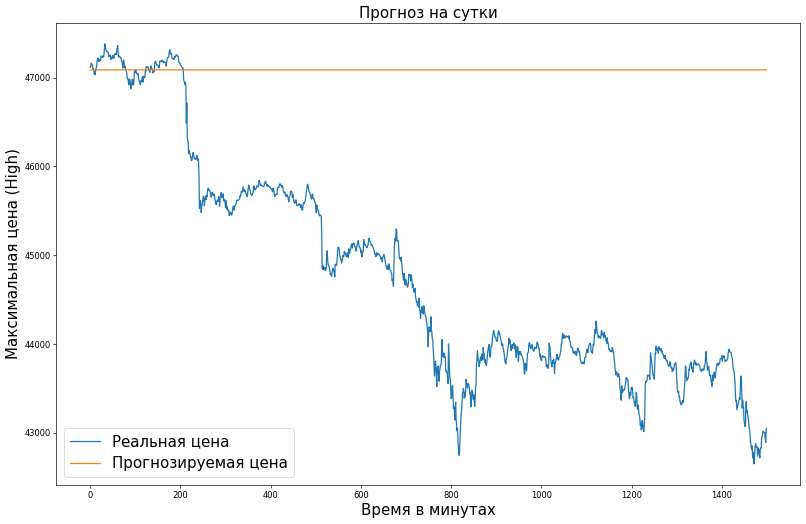

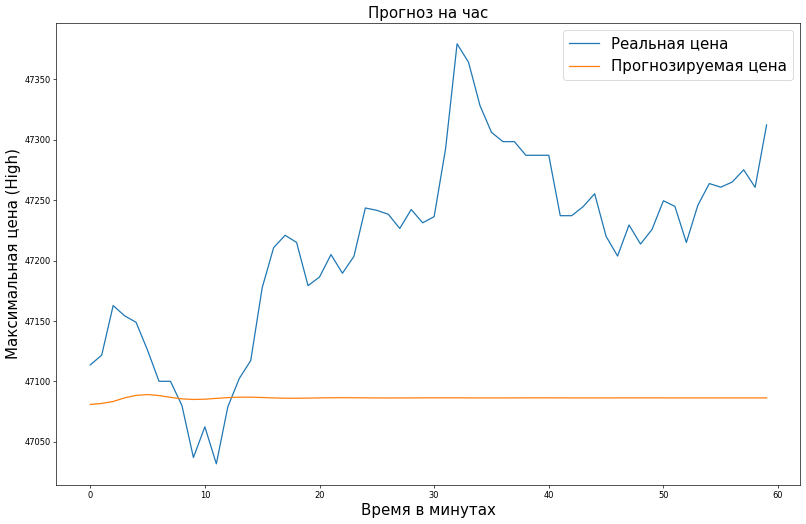

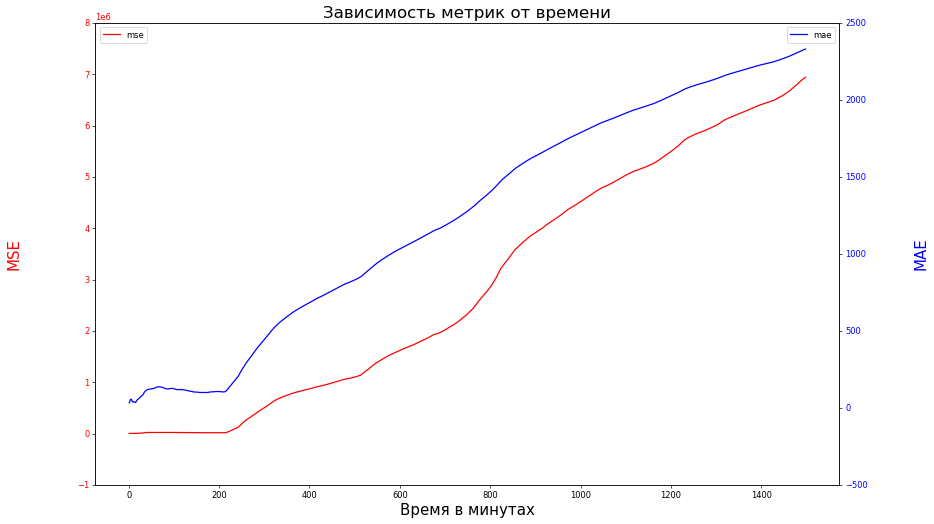

Mean MSE: 6953867.945
Mean MAE: 2332.279


            MSE     MAE
10      1978.87   38.07
60     22576.13  133.20
300   506233.32  446.94
1440 6555185.00 2260.77


In [815]:
forecast = arima_model.forecast(steps = n_test)
plot_forecast_val(test_endog, forecast)
val_to_time(test_endog, forecast)

# SARIMA

In [740]:
import pmdarima as pm
pm.auto_arima(train_endog, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4, model='sarima', trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=194549.595, Time=42.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=194794.031, Time=0.45 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=194714.558, Time=4.64 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=194716.458, Time=5.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=194792.319, Time=0.29 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=194547.379, Time=35.63 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=194560.061, Time=12.02 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=194549.286, Time=107.80 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=194547.439, Time=40.08 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=194551.343, Time=134.28 sec



KeyboardInterrupt



In [741]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_endog, order=(4, 1, 4), seasonal_order=(0, 0, 0, 12)).fit()
sarima_model.save('sarima/sarima_model.pkl')

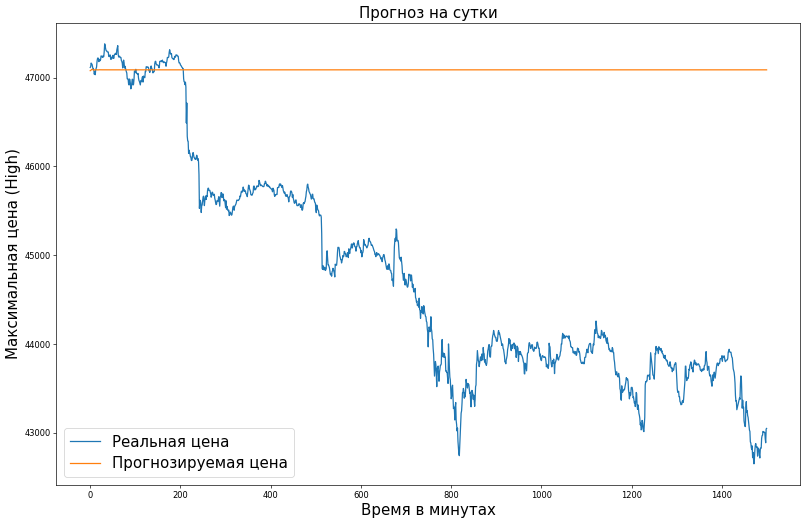

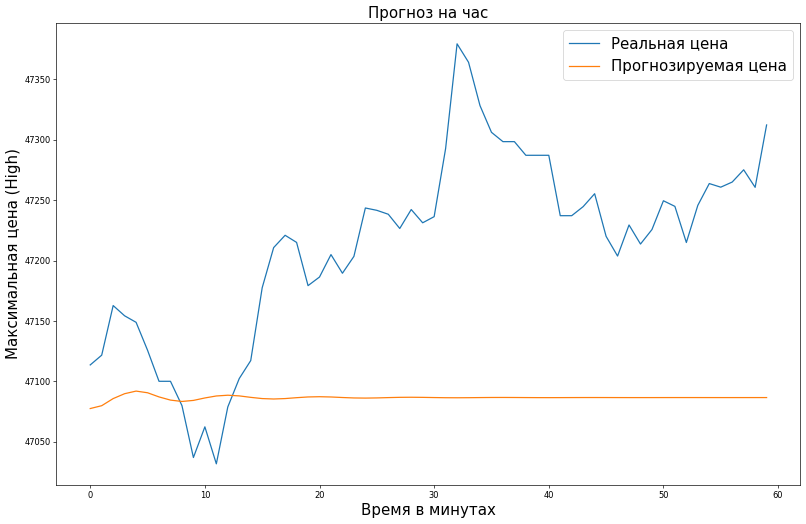

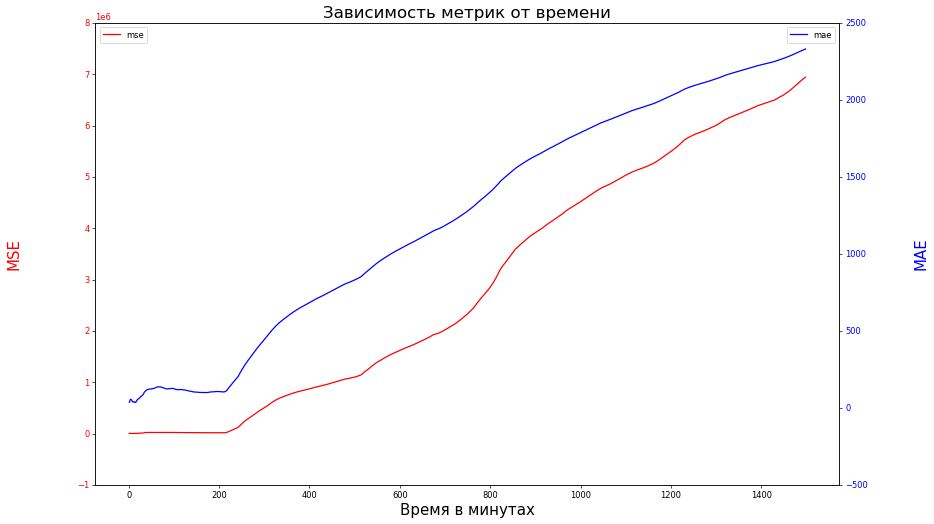

Mean MSE: 6955049.703
Mean MAE: 2332.485


            MSE     MAE
10      1895.40   37.69
60     22509.35  133.02
300   506404.54  446.94
1440 6556329.70 2260.98


In [742]:
forecast = sarima_model.forecast(steps = n_test)
plot_forecast_val(test_endog, forecast)
val_to_time(test_endog, forecast)

# ARIMAX

In [743]:
import pmdarima as pm
pm.auto_arima(train_endog, seasonal=False, exog = train_exog, model='arima', trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=194560.061, Time=11.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=194794.031, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=194721.191, Time=1.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=194722.825, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=194792.319, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=194621.835, Time=7.89 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=194622.963, Time=7.59 sec



KeyboardInterrupt



In [763]:
arimax_model = ARIMA(train_endog, exog = train_exog, order=(5, 1, 2)).fit()
arimax_model.save('arimax/arimax_model.pkl')

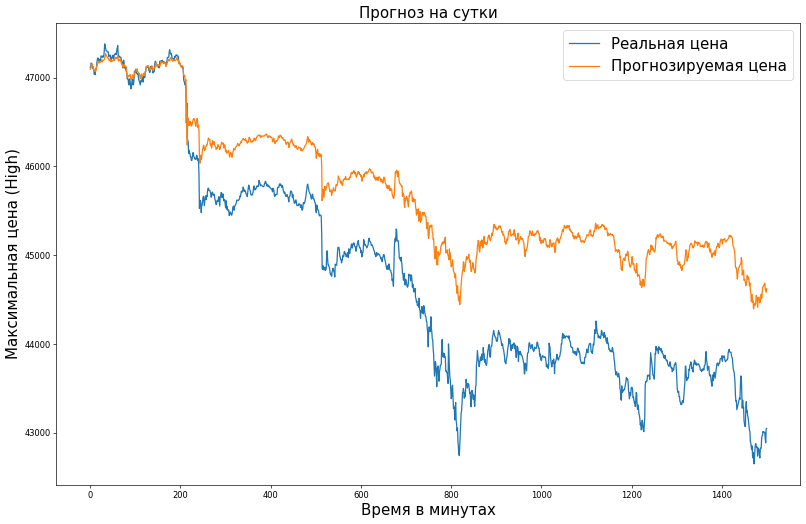

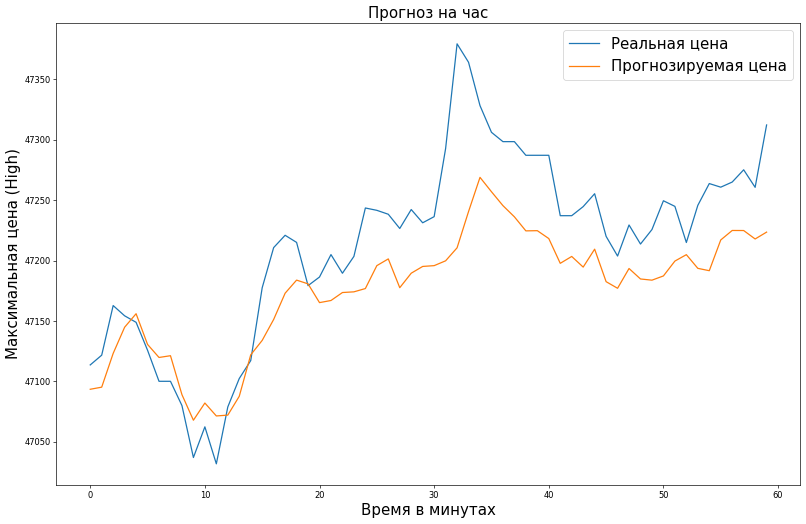

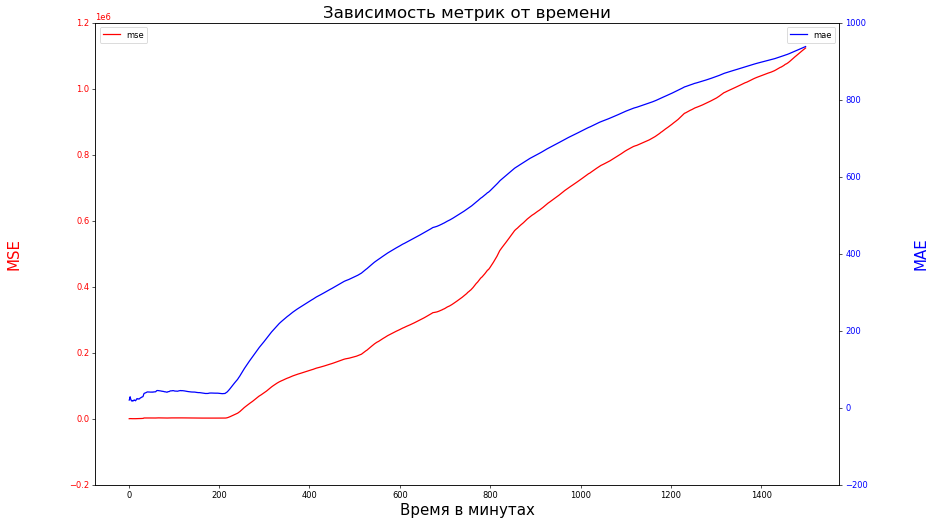

Mean MSE: 1125582.076
Mean MAE: 939.182


            MSE    MAE
10       463.74  18.93
60      2769.42  43.56
300    80510.39 174.46
1440 1064539.66 911.57


In [764]:
forecast = arimax_model.forecast(steps = n_test, exog = test_exog)
plot_forecast_val(test_endog, forecast)
val_to_time(test_endog, forecast)

# SARIMAX

In [287]:
import pmdarima as pm
pm.auto_arima(train_endog, seasonal=True, exog = train_exog, m=12, max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4, model='sarimax', trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=12879.601, Time=4.18 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12914.368, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12909.960, Time=0.72 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12909.839, Time=0.87 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12912.957, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=12877.725, Time=3.71 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=12878.268, Time=1.08 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=12879.675, Time=9.17 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=12877.690, Time=4.41 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=12879.678, Time=13.03 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=11.03 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=12886.993, Time=2.64 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=12895.965, Time=2.47 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=12795.685, Time=2.74 sec
 ARIMA(3,

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -6367.074
Date:                Tue, 20 Jun 2023   AIC                          12752.147
Time:                        04:51:16   BIC                          12796.308
Sample:                    09-07-2021   HQIC                         12768.932
                         - 09-08-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2094      0.083      2.518      0.012       0.046       0.372
ar.L2         -0.0449      0.050     -0.907      0.364      -0.142       0.052
ar.L3         -0.0057      0.042     -0.135      0.893      -0.088       0.077
ar.L4         -0.4632      0.048     -9.634      0.000      -0.557      -0.369
ma.L1         -0.3171      0.089     -3.571      0.000      -0.491      -0.143
ma.L2          0.0660      0.048      1.375      0.169      -0.028       0.160
ma.L3         -0.3547      0.049     -7.276      0.000      -0.450      -0.259
ma.L4          0.5890      0.044     13.528      0.000       0.504       0.674
sigma2      1.971e+04    251.336     78.439      0.000    1.92e+04    2.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            694850.40
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             2.80
Prob(H) (two-sided):                  0.00   Kurtosis:                       132.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [765]:
sarimax_model = SARIMAX(train_endog, exog = train_exog, order=(4, 1, 4), seasonal_order=(0, 0, 0, 12)).fit(disp=True)
sarimax_model.save('sarimax/sarimax_model.pkl')

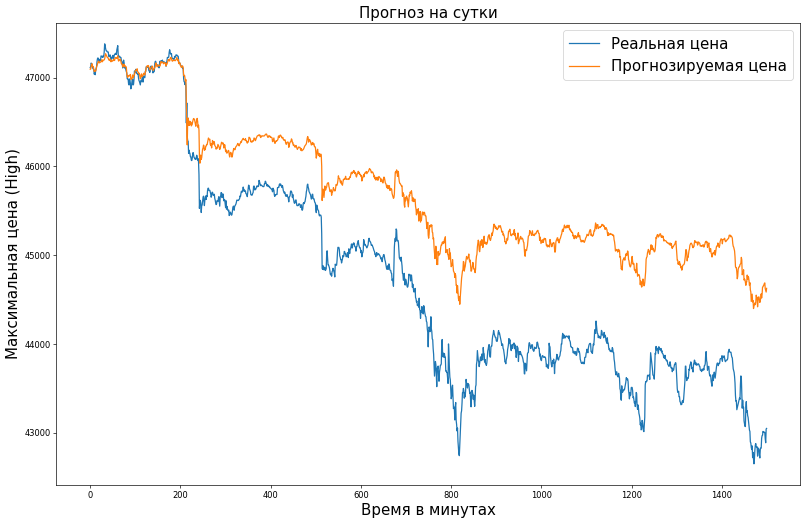

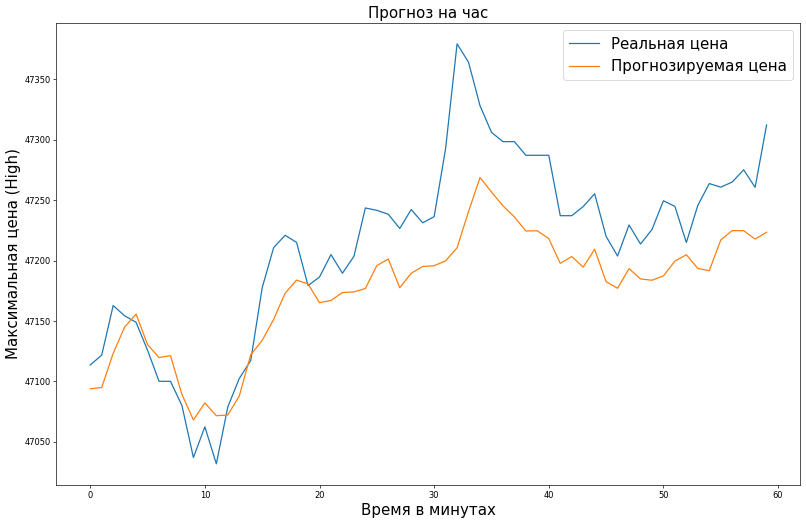

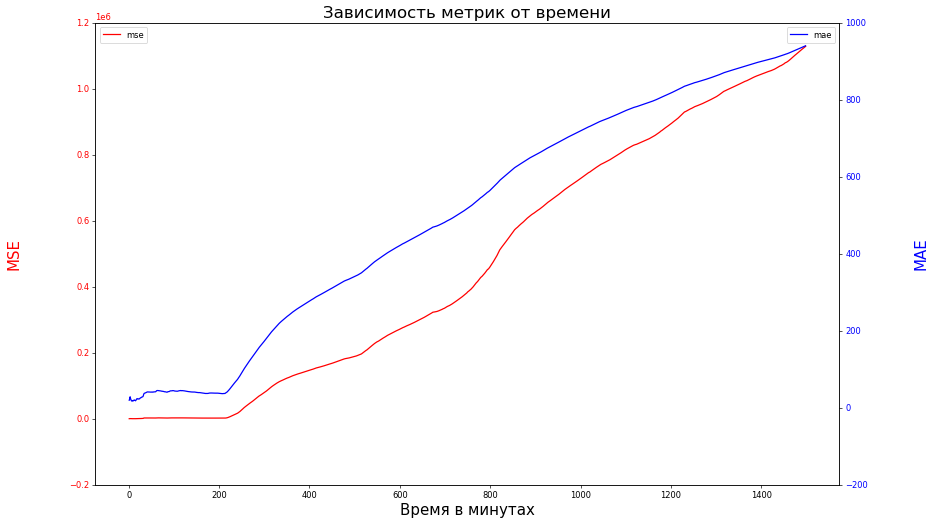

Mean MSE: 1130448.018
Mean MAE: 941.209


            MSE    MAE
10       464.70  18.90
60      2772.67  43.59
300    80870.43 174.83
1440 1069127.17 913.53


In [766]:
forecast = sarimax_model.forecast(steps = n_test, exog = test_exog)
plot_forecast_val(test_endog, forecast)
val_to_time(test_endog, forecast)

# Prophet

In [790]:
df = create_data(data, 0.99)
# df = calculate_indicator(df, 10)
train_data = pd.DataFrame({'ds': df.index, 'y': df['high']})

test_data = train_data[-n_test:]
train_data = train_data[:-n_test]


Созданны данные размером:  (19563, 5)


In [791]:
from prophet import Prophet

model_prophet = Prophet()
model_prophet.fit(train_data)

10:20:19 - cmdstanpy - INFO - Chain [1] start processing
10:20:32 - cmdstanpy - INFO - Chain [1] done processing


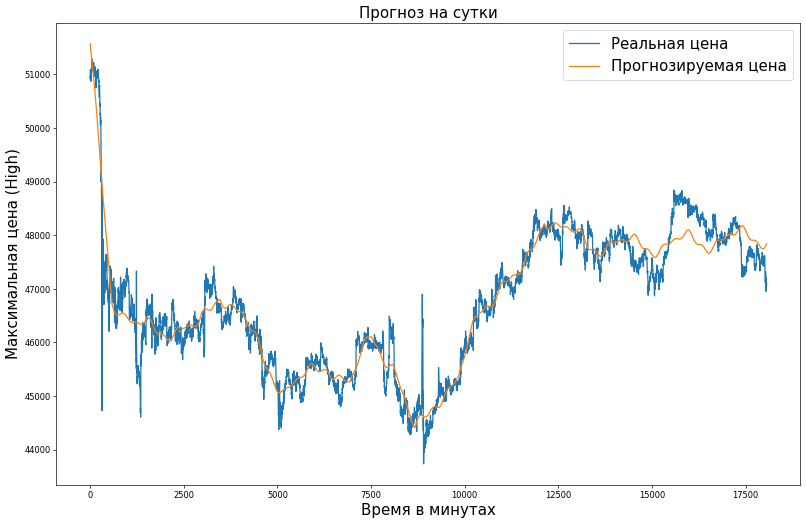

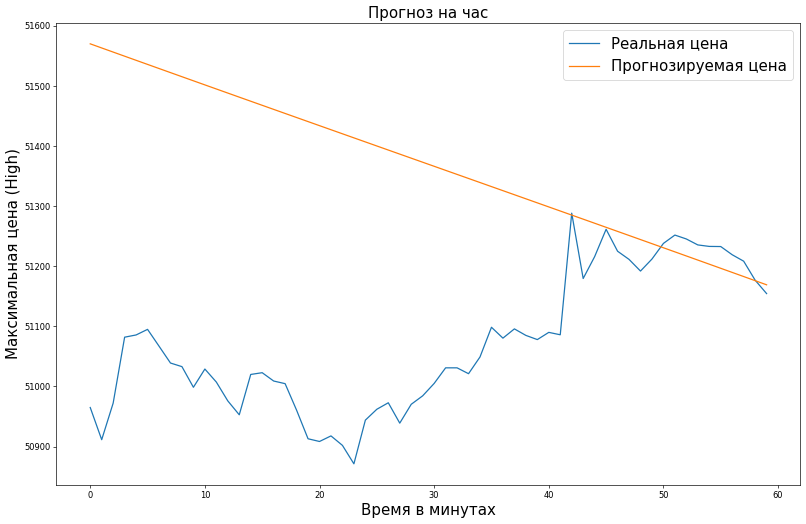

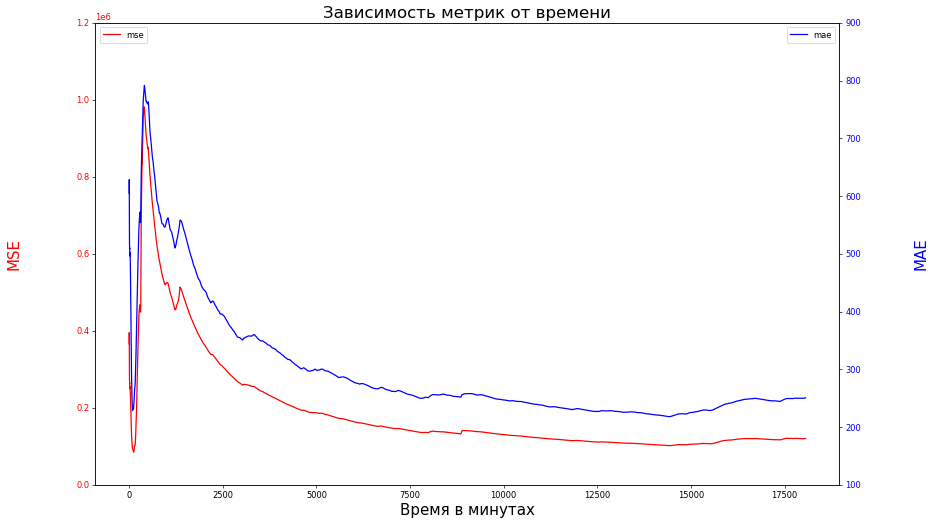

Mean MSE: 120643.549
Mean MAE: 250.805


           MSE    MAE
10   265111.01 510.53
60   133325.23 301.06
300  450077.08 555.10
1440 492155.81 545.54


In [801]:
# future = model_prophet.make_future_dataframe(periods=1, freq='min')
# forecast = model_prophet.predict(future)

# plot_forecast_val(test_data['y'], forecast['yhat'][:n_test])
# val_to_time(test_data['y'], forecast['yhat'][:n_test])
plot_forecast_val(df['high'][:-n_test], forecast['yhat'][:-1])
val_to_time(df['high'][:-n_test], forecast['yhat'][:-1])

In [ ]:
def permutation_feature_importance(X, y, model, metric=mean_squared_error, n_permutations=100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    baseline_score = metric(y_test, model.predict(X_test))
    
    feature_importances = np.zeros(X.shape[1])
    
    for feature in range(X.shape[1]):
        X_permuted = X_test.copy()
        np.random.shuffle(X_permuted[:, feature])  # Перемешиваем значения признака
        
        permuted_score = metric(y_test, model.predict(X_permuted))
        feature_importance = baseline_score - permuted_score
        feature_importances[feature] = feature_importance
    
    return feature_importances

# Пример использования
X = # Ваша матрица признаков
y = # Ваш вектор целевой переменной

model = RandomForestRegressor()
importances = permutation_feature_importance(X, y, model)

# Выводим важности признаков
for feature_importance in importances:
    print(f"Feature Importance: {feature_importance}")

# NeuralProphet

In [800]:
# !pip3 install neuralprophet
from neuralprophet import NeuralProphet

train_data, test_data = train_test_split(create_data(data, 0.99), train_size=0.8, shuffle=False)
train_data = pd.DataFrame({'ds': train_data.index, 'y': train_data['High']})
test_data = pd.DataFrame({'ds': test_data.index, 'y': test_data['High']})

# m = NeuralProphet()
# metrics = m.fit(train_data, validation_df=test_data)

ModuleNotFoundError: No module named 'neuralprophet'

In [142]:
forecast = m.predict(train_data)

INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - T
INFO - (NP.df_utils._infer_frequency) - Major frequency T corresponds to 99.994% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - T


Predicting: 245it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


MSE: 306381.174
MAE: 425.884


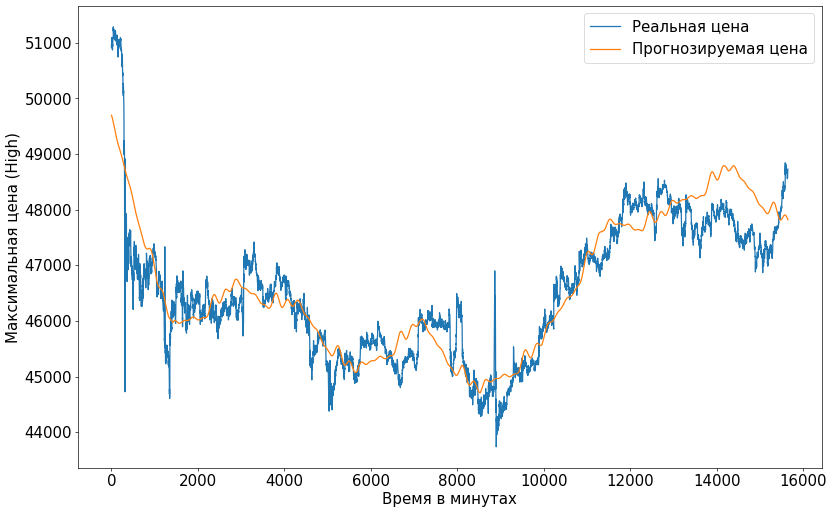

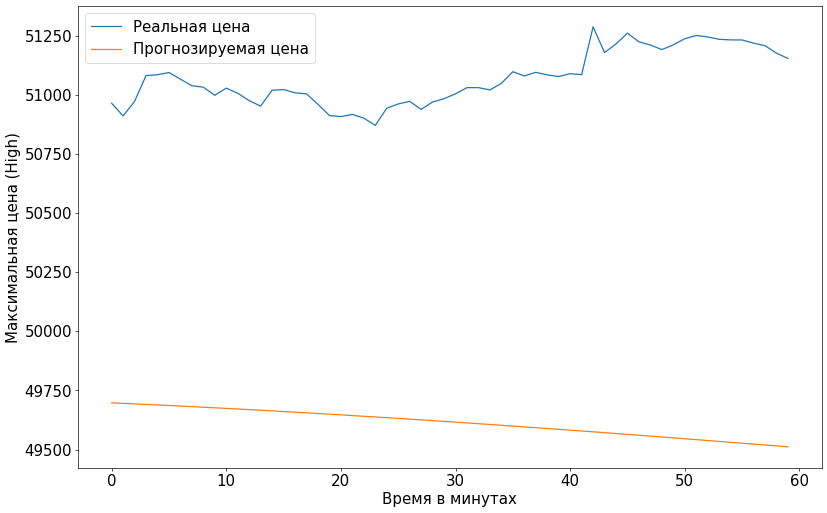

In [143]:
plot_forecast_val(train_data['y'], forecast['yhat1'])

In [25]:
df = create_data(data, 0.999)
df

Созданны данные размером:  (1957, 5)


,open,high,low,close,volume
timestamp,,,,,
2021-09-19 18:24:00,47660.430553,47691.300000,47622.21,47650.082500,31.136631
2021-09-19 18:25:00,47652.531429,47695.440000,47631.80,47684.972857,14.582715
2021-09-19 18:26:00,47687.332857,47705.890000,47665.69,47684.054286,14.218428
2021-09-19 18:27:00,47683.760000,47696.390000,47652.00,47675.777457,17.629179
2021-09-19 18:28:00,47674.770314,47685.790000,47650.00,47665.497143,22.217485
...,...,...,...,...,...
2021-09-21 02:56:00,42983.780000,43001.850849,42878.26,42899.012857,56.850913
2021-09-21 02:57:00,42904.197143,42932.000000,42840.16,42860.005714,80.993326
2021-09-21 02:58:00,42859.385714,42887.500000,42797.20,42827.020000,65.677734


In [26]:
freq = "min"             # the frequency of our data, here daily
context_length    = 180 # train on this number of days
prediction_length =  90 # predict these many days, these are removed from the end of the training data

In [33]:
from gluonts.dataset.common import ListDataset

data_list = [{"start": "2021-09-07 12:58:00", "target": df['high'].values}]
train_ds  = ListDataset(data_iter=data_list,freq=freq)

In [39]:
from gluonts.mx.model.simple_feedforward  import SimpleFeedForwardEstimator
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx import Trainer

estimator = SimpleFeedForwardEstimator(num_hidden_dimensions=[50],
                                       freq=freq,
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=StudentTOutput(),
                                       trainer=Trainer(epochs=50,
                                                       learning_rate=1e-3,
                                                       num_batches_per_epoch=100,
                                                       patience=10))

predictor = estimator.train(train_ds)
print("Done")

ModuleNotFoundError: No module named 'mxnet'

In [42]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,  # dataset
    predictor=predictor,  # predictor
    num_samples=2000,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

NameError: name 'predictor' is not defined

In [7]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervals = (50.0, 90.0)
    legend = ["ground truth", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(color='cadetblue')
    plt.axvline(forecast_entry.start_date, color='g', lw=1) # end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show();
    
plot_prob_forecasts(tss[0], forecasts[0])

NameError: name 'tss' is not defined

In [274]:
import random
df['random'] = [random.uniform(0,1) for i in range(df.shape[0])]
df['random2'] = [random.uniform(0,100) for i in range(df.shape[0])]
df['random3'] = [random.uniform(-100,1000) for i in range(df.shape[0])]

df

,Open,High,Low,Close,Volume,60 period RSI,DI+,DI-,MACD,SIGNAL,...,TENKAN,KIJUN,senkou_span_a,SENKOU,CHIKOU,OBV,VWAP.,random,random2,random3
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 04:26:00,13618.462201,13651.25,13541.06,13617.380000,22.262600,46.179374,6.115192,2.011169,4.564575,8.826915,...,13701.090,13643.890,13725.5525,13699.955,13435.646000,-7.518863e+01,13655.669505,0.424974,10.500139,687.734227
2018-01-01 04:27:00,13649.340000,13840.00,13567.05,13659.444000,13.036082,48.526025,8.744891,1.921872,3.100190,7.681570,...,13701.090,13643.890,13725.5525,13699.955,13420.652000,-6.215255e+01,13655.786089,0.839459,50.541071,61.268051
2018-01-01 04:28:00,13614.312500,13651.21,13568.34,13609.992500,22.824981,46.121805,8.367092,1.838843,3.736663,6.892589,...,13701.090,13643.890,13712.8275,13699.955,13415.950000,-8.497753e+01,13655.505044,0.039615,5.522812,121.024958
2018-01-01 04:29:00,13610.237500,13651.00,13534.55,13611.250000,25.822327,46.190747,8.014959,2.263434,4.247390,6.363549,...,13701.090,13643.890,13712.8275,13700.950,13373.680000,-5.915521e+01,13655.116190,0.306861,80.735334,976.474123
2018-01-01 04:30:00,13643.916000,13778.60,13557.98,13643.486000,10.417401,47.927787,9.541676,2.170538,3.416188,5.774077,...,13701.090,13643.890,13712.8275,13700.950,13346.488000,-4.873781e+01,13655.129756,0.034114,84.917164,731.427099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-21 02:30:00,42675.717500,42779.10,42575.00,42600.396250,267.308816,37.226091,17.955456,30.611079,242.186976,212.985809,...,43257.500,43015.000,43464.0450,43471.920,42899.012857,-1.930622e+06,16727.140013,0.101744,79.273311,134.944688
2021-09-21 02:31:00,42599.647143,42703.01,42579.40,42624.280000,133.451735,37.702606,17.656198,30.100895,248.894038,220.167455,...,43257.500,42970.500,43463.6025,43471.920,42860.005714,-1.930489e+06,16727.159048,0.002734,92.777512,908.450715
2021-09-21 02:32:00,42620.293750,42650.00,42515.09,42577.000000,220.404511,37.135118,17.361928,30.408067,256.248246,227.383613,...,43227.545,42940.545,43463.6025,43471.920,42827.020000,-1.930709e+06,16727.190420,0.135460,4.820046,23.091193


In [134]:
# def generate_examples(data, lookback):
#     n = data.shape[0] - lookback
#     features = np.zeros((n, lookback, 1))
#     targets = data[lookback:, 1]
#     for i, j in enumerate(range(n)):
#         features[i] = data[j:j+lookback, 1:2]
#     return features, targets

# lookback = 60

# import time
# start_time = time.time()
# X_train, y_train = generate_examples(train_data.values, lookback)
# X_test, y_test = generate_examples(test_data.values, lookback)
# print("--- %s seconds ---" % (time.time() - start_time), X_train.shape)



def generate_examples(data, lookback):
    n = data.shape[0] - lookback
    features = np.zeros((n, lookback, data.shape[1]))
    targets = data[lookback:, 0]
    for i, j in tqdm(enumerate(range(n)), desc='Выполнение'):
        features[i] = data[j:j+lookback]
    return features, targets


df = create_data(data[['timestamp','High']], 0.99)
# df = calculate_indicator(df, 20)

lookback = 60
X, y = generate_examples(df.values, lookback)

Созданны данные размером:  (19563, 1)


Выполнение: 0it [00:00, ?it/s]

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)

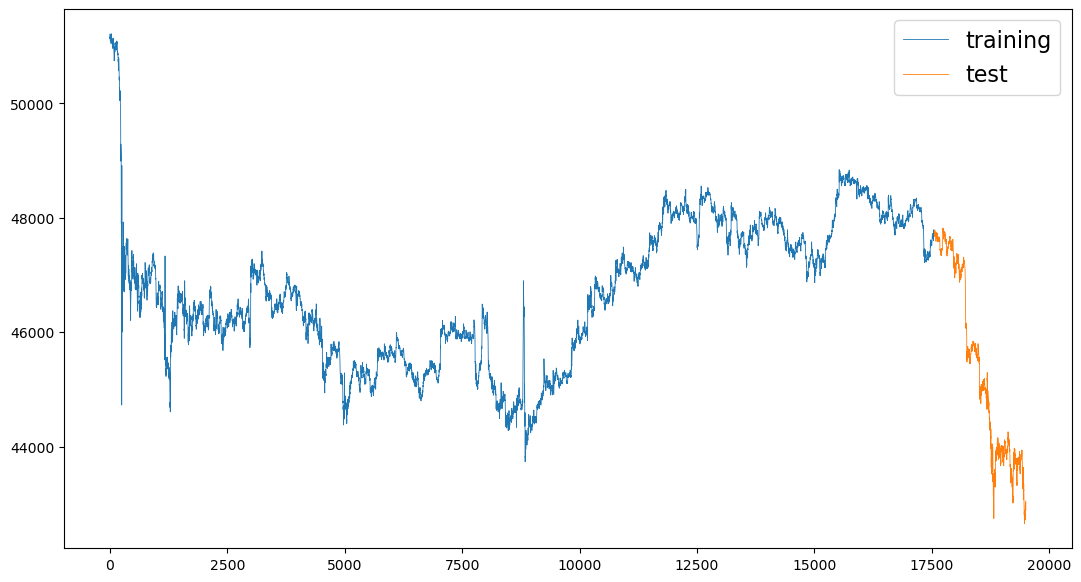

In [136]:
def line_plot(y1, y2, label1=None, label2=None, title='', lw=0.6):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    x1 = range(y1.shape[0])
    x2 = range(y1.shape[0], y1.shape[0]+y2.shape[0])
    ax.plot(x1, y1, label=label1, linewidth=lw)
    ax.plot(x2, y2, label=label2, linewidth=lw)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(y_train, y_test, 'training', 'test', title='')

In [137]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True, random_state = 43)

In [138]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test = x_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
X_val = x_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
y_val = y_scaler.transform(y_val.reshape(-1, 1))
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)

X_train: (14041, 60, 1)
X_val: (3511, 60, 1)
X_test: (1951, 60, 1)
y_train: (14041, 1)
y_val: (3511, 1)
y_test: (1951, 1)


In [139]:
# from joblib import dump, load

# dump(x_scaler, 'x_scaler.joblib')
# dump(y_scaler, 'y_scaler.joblib')

# loaded_scaler = load('scaler.joblib')


In [140]:
def predict_invers_transform(X_test, y_test, model):
    preds = model.predict(X_test)
    actual = y_scaler.inverse_transform(y_test).flatten()
    pred = y_scaler.inverse_transform(preds).flatten()    
    return actual, preds

#     MAE = mean_absolute_error(actual, preds)
#     print("MAE", MAE)
#     MSE=mean_squared_error(actual, preds)
#     print("MSE", MSE)
#     R2=r2_score(actual, preds)
#     print("R2", R2)
#     print("\t MAE\t\t\t MSE\t\t\t R2")
#     for col in df_actual.columns:
#         print(col,"\t",
#         mean_absolute_error(df_actual[col].values, df_preds[col].values),"\t",
#         mean_squared_error(df_actual[col].values, df_preds[col].values),"\t",
#         r2_score(df_actual[col].values, df_preds[col].values))


    
#     from tabulate import tabulate
#     headers = ["High"]
#     print(tabulate(df_actual.iloc[-10:].values, headers=headers))
#     print('\n')
#     print(tabulate(df_preds.iloc[-10:].values, headers=headers))
    
#     plot_forecast_val(df_actual['High'].values, df_preds['High'].values)
#     val_to_time(df_actual['High'].values, df_preds['High'].values)
    
#     import plotly.express as px
#     import plotly.graph_objs as go
#     from plotly.subplots import make_subplots
#     from plotly.graph_objs import Candlestick

#     fig = make_subplots(rows=0.5, cols=1)
#     fig.add_trace(go.Scatter(y=df_actual['High'].values, name=f'A High')) 
#     fig.add_trace(go.Scatter(y=df_preds['High'].values, name=f'P High'))
#     fig.update_layout(title_text='Candlestick Chart', hovermode='x')
#     fig.update_xaxes(title_text='Date', row=1, col=1, showgrid=True)
#     fig.update_yaxes(title_text='Price', row=1, col=1, showgrid=True)
#     fig.show()

In [141]:
import keras.backend as K

def log_mse(y_true, y_pred):
    y_true_log = tf.math.log1p(y_true)
    y_pred_log = tf.math.log1p(y_pred)
    log_mse = tf.losses.mean_squared_error(y_true_log, y_pred_log)
    return log_mse

def rmse_loss(y_true, y_pred):
    mse = tf.losses.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    return rmse

def huber_mse(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    condition = K.abs(error) < delta

    squared_loss = 0.5 * K.square(error)
    linear_loss = delta * (K.abs(error) - 0.5 * delta)

    return K.mean(tf.where(condition, squared_loss, linear_loss))

In [142]:
# LSTM
def model_learn(X_train, y_train, X_val, y_val):
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, LeakyReLU, Bidirectional
    from tensorflow.keras.optimizers import RMSprop
    from tensorflow.keras import regularizers
    from tensorflow.keras.callbacks import EarlyStopping,TensorBoard,ReduceLROnPlateau,ModelCheckpoint

    lstm_neurons = 84
    output_size = 1
    epochs = 20 
    batch_size = 20
    dropout = 0.1
    loss = 'mse'
    optimizer = 'adam'
    activ_func = "linear"

    def build_lstm_model(input_data, output_size, neurons, activ_func=activ_func,
                          dropout=dropout, loss=loss, optimizer=optimizer):

        model = Sequential()
        model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
        model.add(Dropout(0.1))
        model.add(Dense(output_size, activation=activ_func))
        model.compile(loss=loss, optimizer=optimizer)
        return model

    model = build_lstm_model(X_train, 
                             output_size=output_size, 
                             neurons=lstm_neurons, 
                             dropout=dropout, 
                             loss=loss,
                             optimizer=optimizer)

    checkpoint_path = "model_checkpoint.h5"
    checkpoint = ModelCheckpoint(checkpoint_path, 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='min')



    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00000001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)


    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=1, 
                        shuffle=False,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,  early_stopping])

    model.save('LSTM.h5')


    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return model

Epoch 1/20
703/703 [==============================] - ETA: 0s - loss: 0.0017
Epoch 1: val_loss improved from inf to 0.00031, saving model to model_checkpoint.h5
703/703 [==============================] - 19s 23ms/step - loss: 0.0017 - val_loss: 3.1129e-04
Epoch 2/20
701/703 [============================>.] - ETA: 0s - loss: 4.1891e-04
Epoch 2: val_loss improved from 0.00031 to 0.00015, saving model to model_checkpoint.h5
703/703 [==============================] - 17s 24ms/step - loss: 4.1877e-04 - val_loss: 1.4815e-04
Epoch 3/20
702/703 [============================>.] - ETA: 0s - loss: 3.8065e-04
Epoch 3: val_loss did not improve from 0.00015
703/703 [==============================] - 16s 23ms/step - loss: 3.8071e-04 - val_loss: 2.7672e-04
Epoch 4/20
703/703 [==============================] - ETA: 0s - loss: 3.2876e-04
Epoch 4: val_loss improved from 0.00015 to 0.00013, saving model to model_checkpoint.h5
703/703 [==============================] - 16s 23ms/step - loss: 3.2876e-04 - va

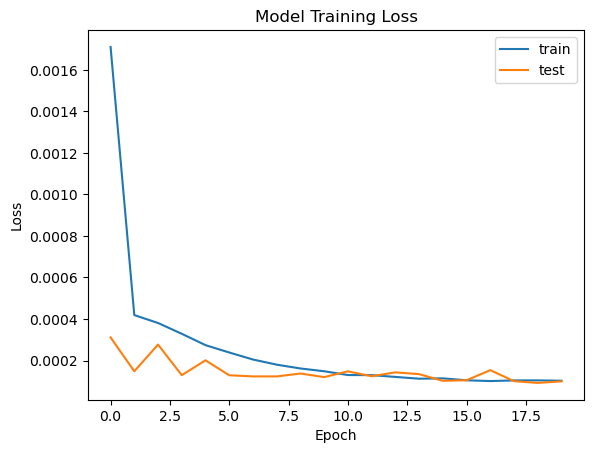

61/61 [==============================] - 1s 9ms/step
Mean MSE: 3285.766
Mean MAE: 40.320


         MSE   MAE
10    557.89 19.98
60   1258.91 30.43
300  1478.44 32.05
1440 3220.12 40.21


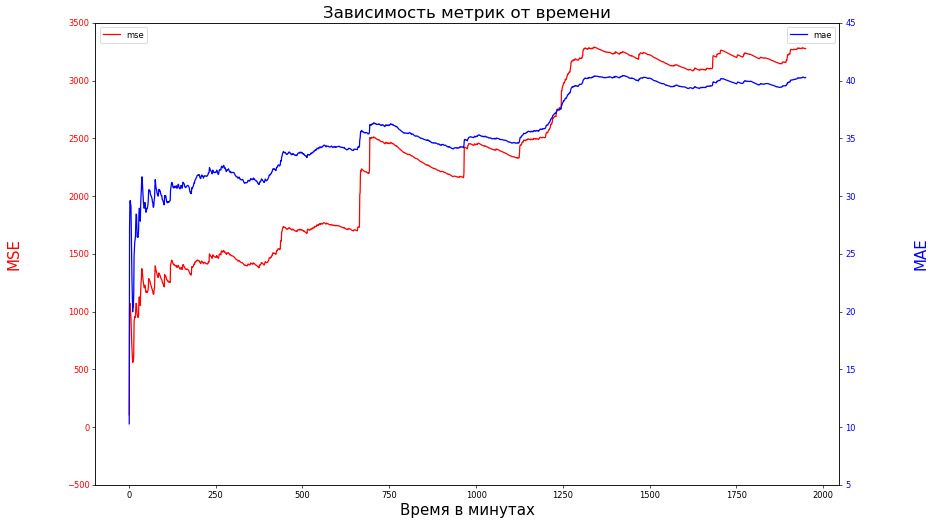

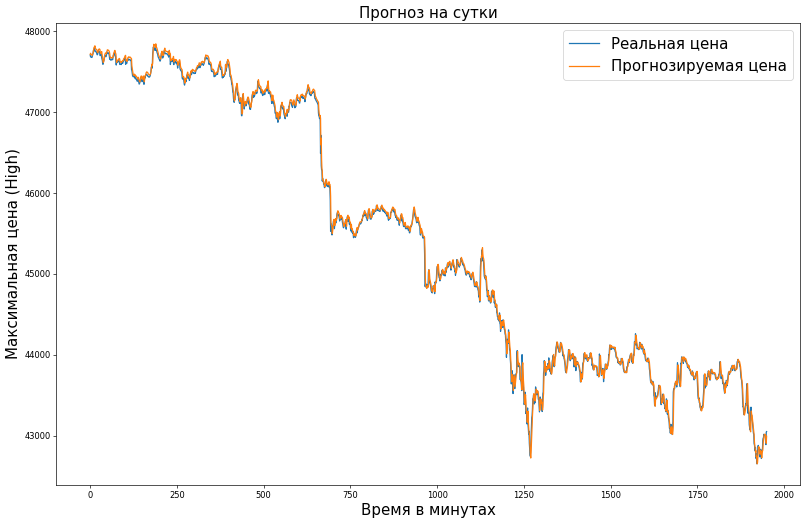

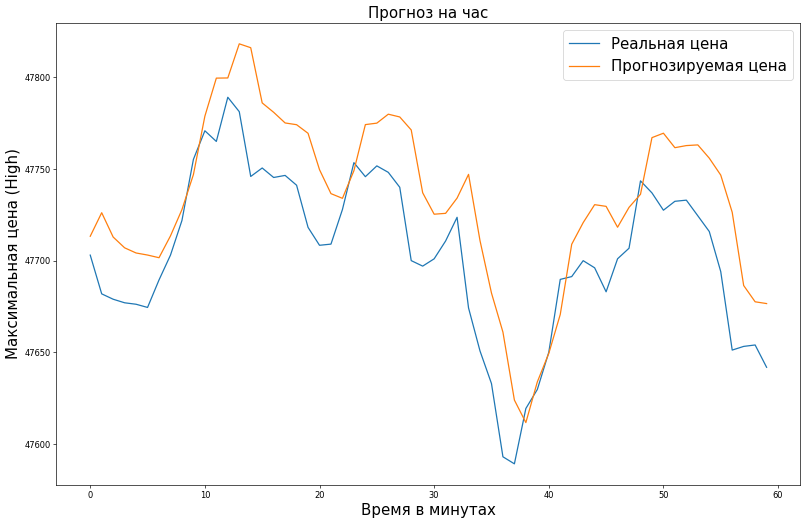

In [143]:
model = model_learn(X_train, y_train, X_val, y_val)
pred = model.predict(X_test)
actual = y_scaler.inverse_transform(y_test).flatten()
pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

# pred = predict_invers_transform(X_test[-1600:], y_test[-1601:-1], gru_model)
val_to_time(actual, pred)
plot_forecast_val(actual, pred)

In [116]:
# mse
# Mean MSE: 2869.257
# Mean MAE: 41.041

# huber_mse
# Mean MSE: 4300.902
# Mean MAE: 50.668

# log_mse
# Mean MSE: 5609.653
# Mean MAE: 62.961


# smart_money

# mse
# Mean MSE: 42562.533
# Mean MAE: 180.775

# huber_mse
# Mean MSE: 7357.366
# Mean MAE: 66.417


 Computing LSTM feature importance...


  0%|          | 0/104 [00:00<?, ?it/s]

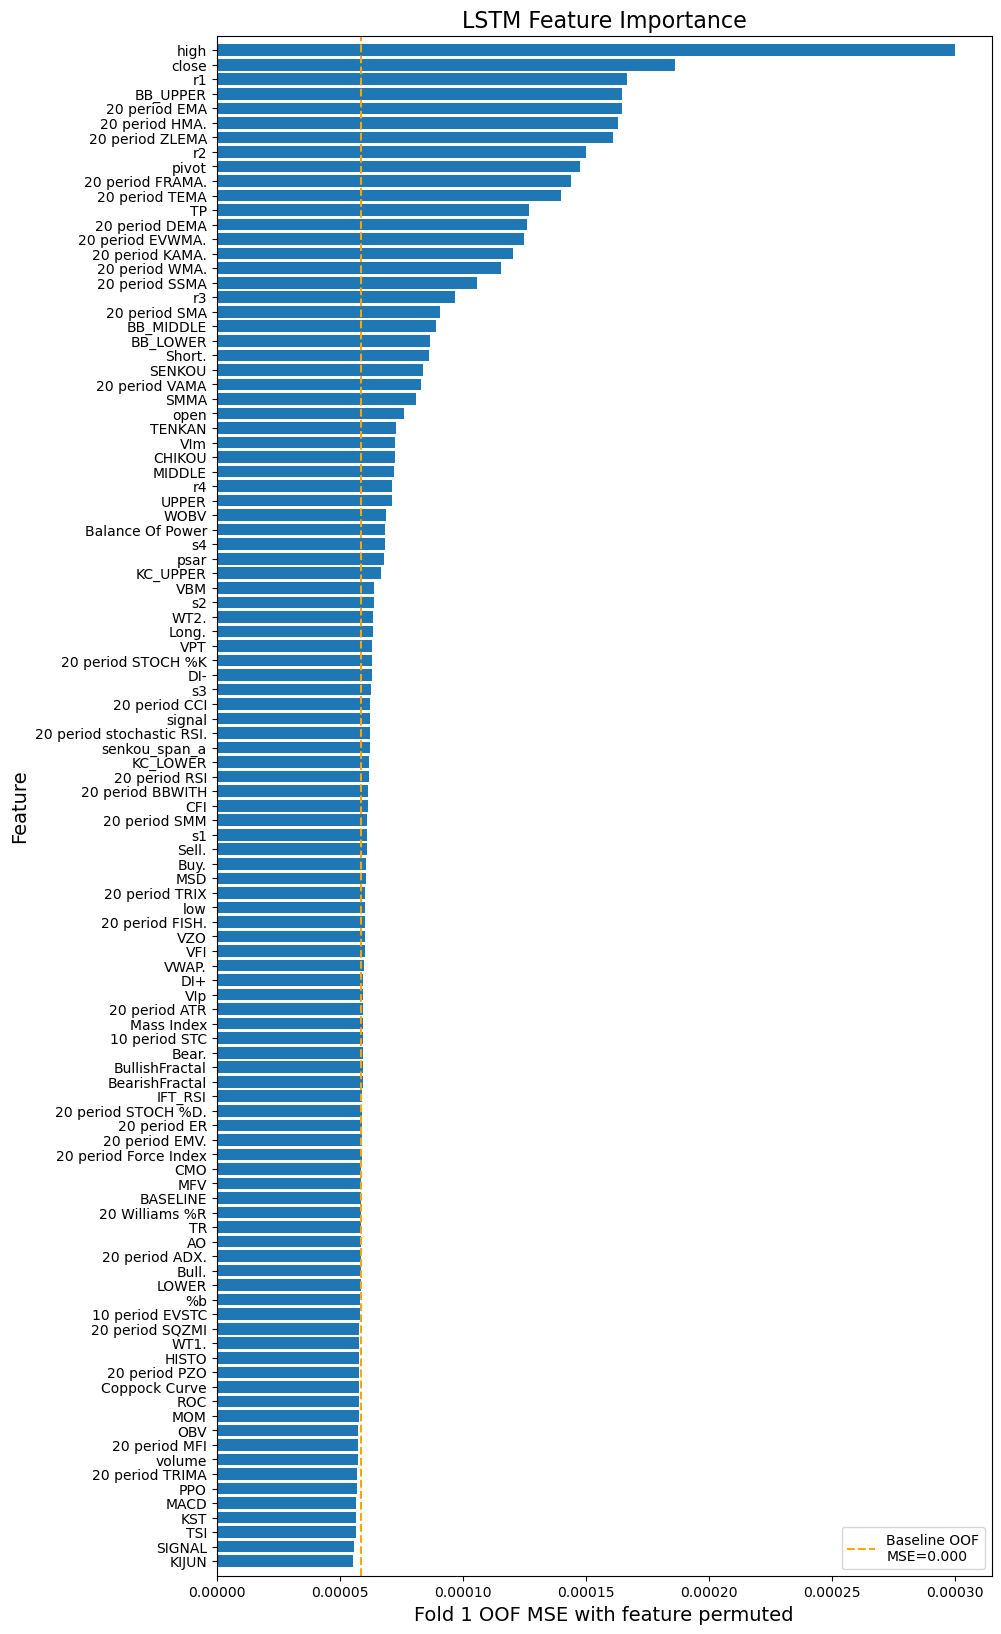

In [125]:
from tensorflow import keras

COLS = list(df.columns)

gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    K.clear_session()
    results = []
    print(' Computing LSTM feature importance...')

    # COMPUTE BASELINE (NO SHUFFLE)
    preds = model.predict(X_test, verbose=0).squeeze() 
    baseline_mse = mean_squared_error(y_test, preds)
    results.append({'feature':'BASELINE','mse':baseline_mse})           

    for k in tqdm(range(len(COLS))):

        # SHUFFLE FEATURE K
        save_col = X_test[:,:,k].copy()
        np.random.shuffle(X_test[:,:,k])

        # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
        preds = model.predict(X_test, verbose=0).squeeze() 
        mse = mean_squared_error(y_test, preds)
        results.append({'feature':COLS[k],'mse':mse})
        X_test[:,:,k] = save_col
        
    # DISPLAY LSTM FEATURE IMPORTANCE
    print()
    df_res = pd.DataFrame(results)
    df_res = df_res.sort_values('mse')
    plt.figure(figsize=(10,20))
    plt.barh(np.arange(len(COLS)+1),df_res.mse)
    plt.yticks(np.arange(len(COLS)+1),df_res.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,len(COLS)+1))
    plt.plot([baseline_mse,baseline_mse],[-1,len(COLS)+1], '--', color='orange',
                label=f'Baseline OOF\nMSE={baseline_mse:.3f}')
    plt.xlabel(f'Fold {fold+1} OOF MSE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()

Созданны данные размером:  (19563, 5)


Вычисление индикаторов:   0%|          | 0/90 [00:00<?, ?it/s]

Размер данных до вычисления индикаторов:  (19563, 5)
Размер данных после вычисления индикаторов:  (19460, 104)


Выполнение: 0it [00:00, ?it/s]

Epoch 1/20
697/699 [============================>.] - ETA: 0s - loss: 0.0036
Epoch 1: val_loss improved from inf to 0.00026, saving model to model_checkpoint.h5
699/699 [==============================] - 22s 25ms/step - loss: 0.0036 - val_loss: 2.5552e-04
Epoch 2/20
696/699 [============================>.] - ETA: 0s - loss: 9.2494e-04
Epoch 2: val_loss improved from 0.00026 to 0.00015, saving model to model_checkpoint.h5
699/699 [==============================] - 14s 20ms/step - loss: 9.2350e-04 - val_loss: 1.5234e-04
Epoch 3/20
699/699 [==============================] - ETA: 0s - loss: 7.9668e-04
Epoch 3: val_loss improved from 0.00015 to 0.00014, saving model to model_checkpoint.h5
699/699 [==============================] - 14s 20ms/step - loss: 7.9668e-04 - val_loss: 1.3970e-04
Epoch 4/20
699/699 [==============================] - ETA: 0s - loss: 6.4972e-04
Epoch 4: val_loss improved from 0.00014 to 0.00008, saving model to model_checkpoint.h5
699/699 [==============================

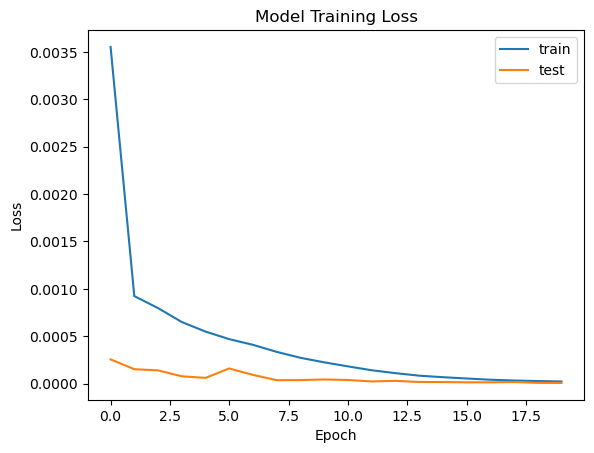

61/61 [==============================] - 1s 9ms/step
Mean MSE: 0.942
Mean MAE: 0.639


      MSE  MAE
10   0.24 0.43
60   0.16 0.28
300  0.31 0.36
1440 0.90 0.61


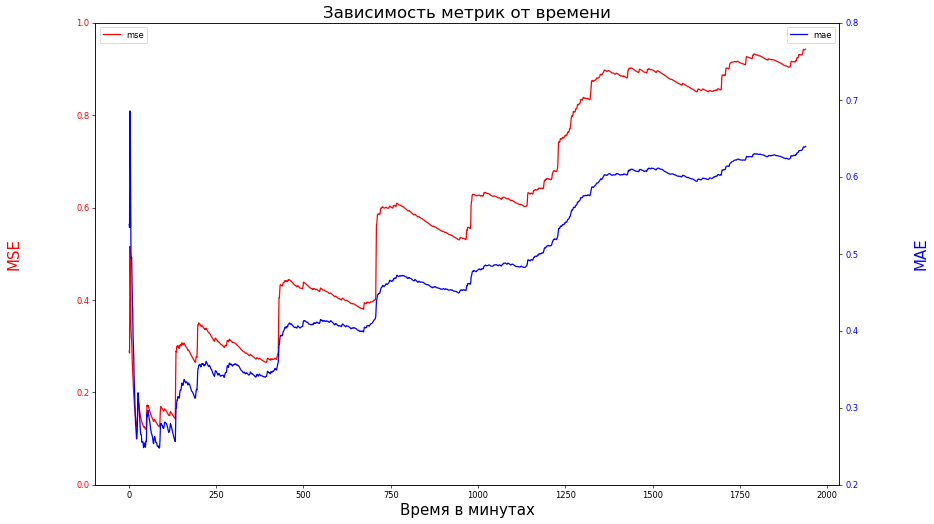

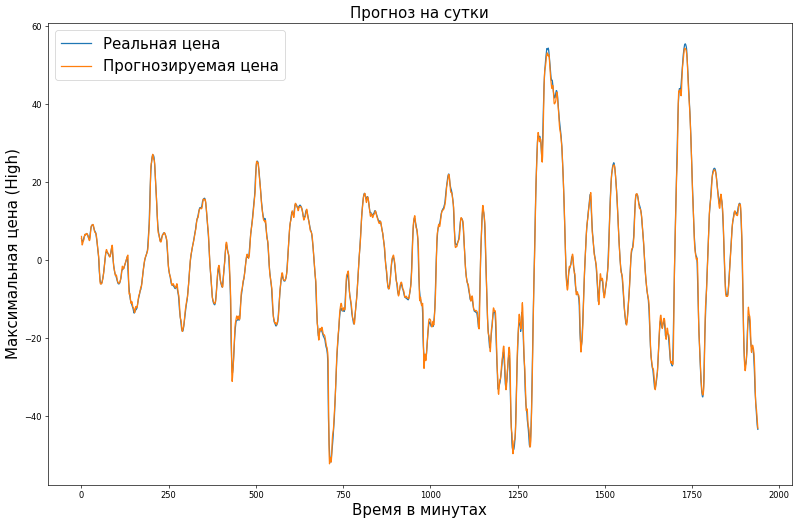

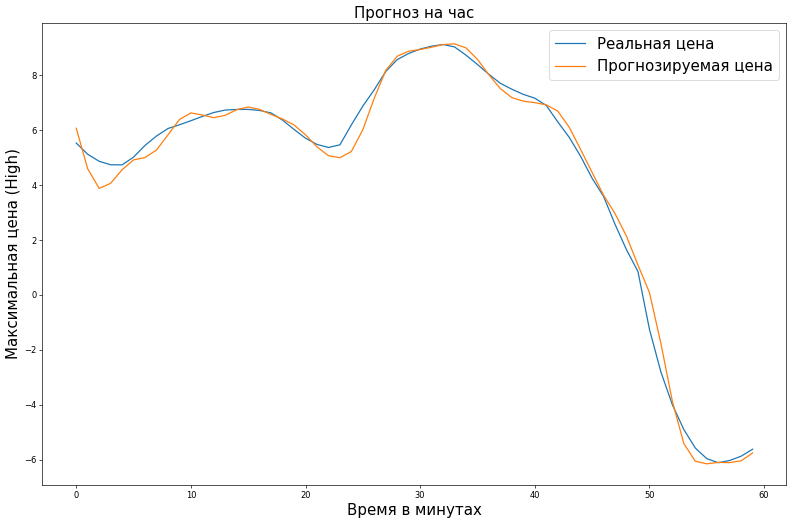

In [127]:
best_feature = list(df_res['feature'][:2].values)

def relearn(best_feature):
    lookback = 60
    df = create_data(data, 0.99)
    df = calculate_indicator(df, 20)
    X, y = generate_examples(df[best_feature].values, lookback)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = True, random_state = 43)
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X_train = x_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
    X_test = x_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
    X_val = x_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.reshape(-1, 1))
    y_val = y_scaler.transform(y_val.reshape(-1, 1))
    model = model_learn(X_train, y_train, X_val, y_val)
    pred = model.predict(X_test)
    actual = y_scaler.inverse_transform(y_test).flatten()
    pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
    val_to_time(actual, pred)
    plot_forecast_val(actual, pred)
    return model

model = relearn(best_feature)

In [ ]:
Mean MSE: 2280.393
Mean MAE: 29.573



Epoch 1/20
385/389 [============================>.] - ETA: 0s - loss: 0.0101
Epoch 1: val_loss improved from inf to 0.00108, saving model to gru_model_checkpoint.h5
389/389 [==============================] - 9s 15ms/step - loss: 0.0100 - val_loss: 0.0011
Epoch 2/20
388/389 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 2: val_loss improved from 0.00108 to 0.00062, saving model to gru_model_checkpoint.h5
389/389 [==============================] - 5s 12ms/step - loss: 0.0018 - val_loss: 6.1979e-04
Epoch 3/20
387/389 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 3: val_loss improved from 0.00062 to 0.00050, saving model to gru_model_checkpoint.h5
389/389 [==============================] - 5s 12ms/step - loss: 0.0011 - val_loss: 5.0202e-04
Epoch 4/20
385/389 [============================>.] - ETA: 0s - loss: 7.5718e-04
Epoch 4: val_loss did not improve from 0.00050
389/389 [==============================] - 5s 12ms/step - loss: 7.5594e-04 - val_loss: 5.41

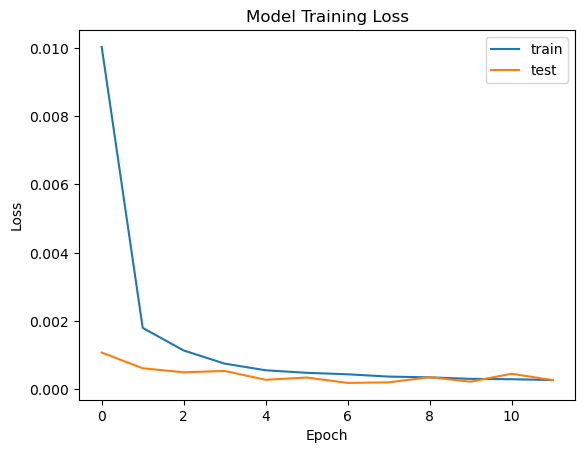

In [69]:
# gru

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GRU, Conv1D, MaxPooling1D, Dropout, Flatten, LeakyReLU, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard,ReduceLROnPlateau,ModelCheckpoint

gru_neurons = 84
output_size = 1
epochs = 20 
batch_size = 20
dropout = 0.1
loss = 'mse'
optimizer = 'adam'
activ_func = "linear"

def build_gru_model(input_data, output_size, neurons, activ_func=activ_func,
                      dropout=dropout, loss=loss, optimizer=optimizer):

    gru_model = Sequential()
    gru_model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    gru_model.add(Dropout(0.1))
    gru_model.add(Dense(output_size, activation=activ_func))
    gru_model.compile(loss=loss, optimizer=optimizer)
    return gru_model

gru_model = build_gru_model(X_train, 
                         output_size=output_size, 
                         neurons=gru_neurons, 
                         dropout=dropout, 
                         loss=loss,
                         optimizer=optimizer)

checkpoint_path = "gru_model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = gru_model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    shuffle=False,
                    use_multiprocessing=True,
                    callbacks=[checkpoint,  early_stopping])

gru_model.save('gru.h5')


plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

304/304 [==============================] - 2s 6ms/step
Mean MSE: 17384.937
Mean MAE: 124.719


          MSE    MAE
10    4570.07  64.15
60   10540.83  99.45
300  12384.34 103.62
1440 12328.40 102.14


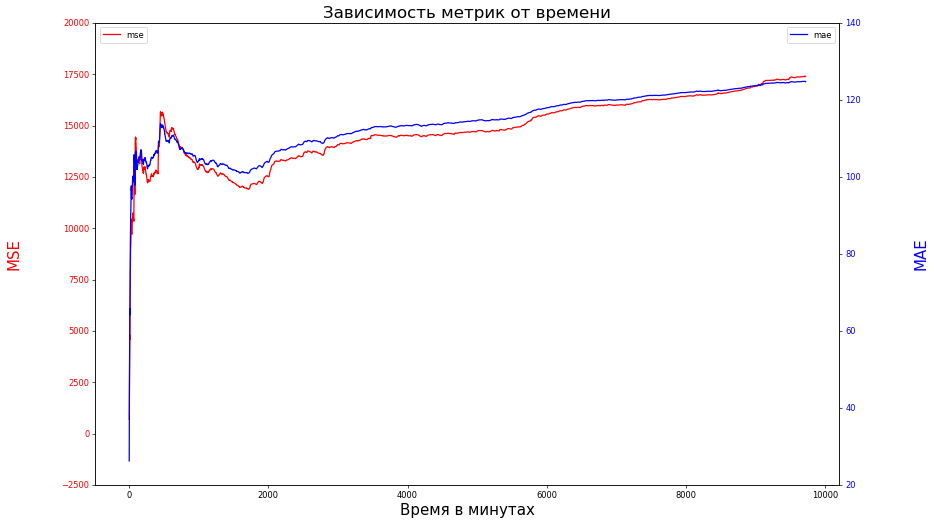

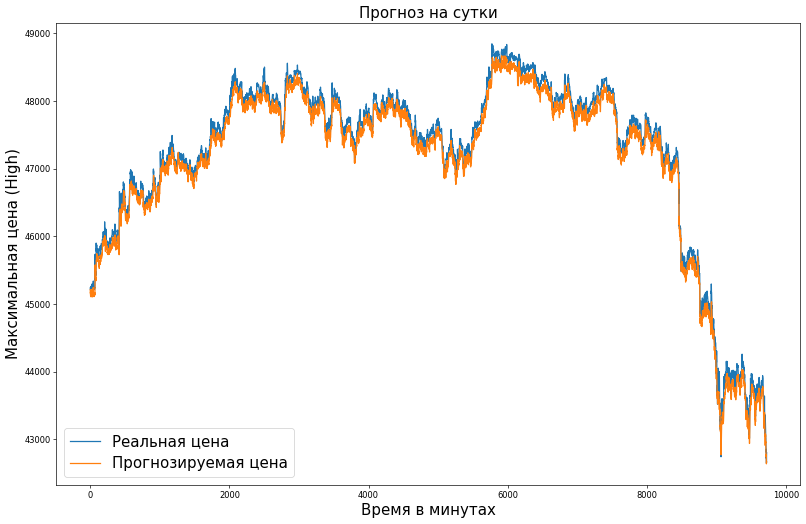

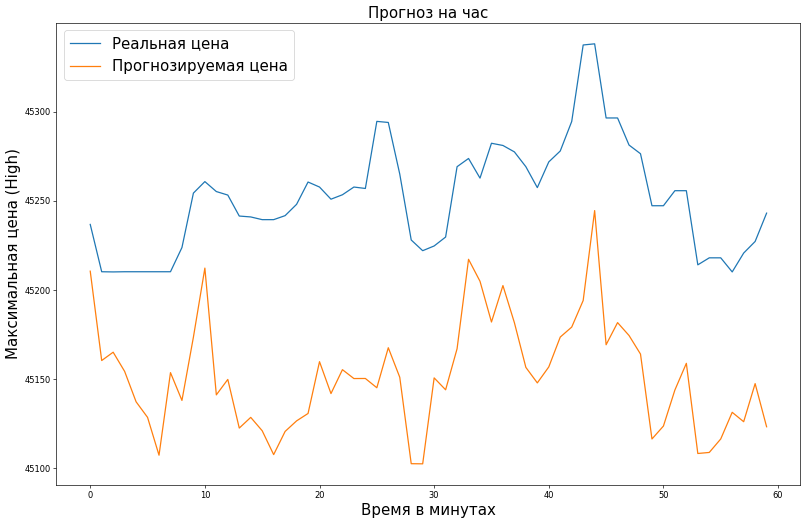

In [89]:
pred = gru_model.predict(X_test)
actual = y_scaler.inverse_transform(y_test).flatten()
pred = y_scaler.inverse_transform(pred).flatten()

# pred = predict_invers_transform(X_test[-1600:], y_test[-1601:-1], gru_model)
val_to_time(actual, pred)
plot_forecast_val(actual, pred)

Epoch 1/5
389/389 [==============================] - ETA: 0s - loss: 0.0214
Epoch 1: val_loss improved from inf to 0.00154, saving model to cnn_model_checkpoint.h5
389/389 [==============================] - 9s 10ms/step - loss: 0.0214 - val_loss: 0.0015
Epoch 2/5
388/389 [============================>.] - ETA: 0s - loss: 0.0038
Epoch 2: val_loss improved from 0.00154 to 0.00105, saving model to cnn_model_checkpoint.h5
389/389 [==============================] - 3s 9ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 3/5
384/389 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 3: val_loss improved from 0.00105 to 0.00064, saving model to cnn_model_checkpoint.h5
389/389 [==============================] - 3s 9ms/step - loss: 0.0026 - val_loss: 6.3831e-04
Epoch 4/5
387/389 [============================>.] - ETA: 0s - loss: 0.0020
Epoch 4: val_loss improved from 0.00064 to 0.00054, saving model to cnn_model_checkpoint.h5
389/389 [==============================] - 3s 9ms/step - los

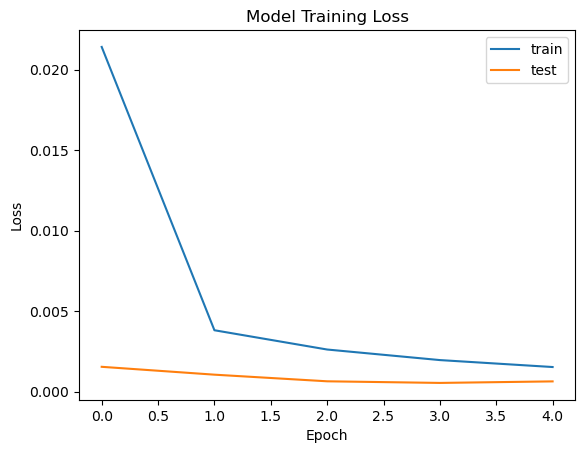

In [71]:
# cnn

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, LeakyReLU, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard,ReduceLROnPlateau,ModelCheckpoint

cnn_neurons = 84
output_size = 1
epochs = 5 
batch_size = 20
dropout = 0.1
loss = 'mse'
optimizer = 'adam'
activ_func = "linear"

def build_cnn_model(input_data, output_size, neurons, activ_func=activ_func,
                      dropout=dropout, loss=loss, optimizer=optimizer):

    cnn_model = Sequential()
    cnn_model.add(Conv1D(neurons, kernel_size=1, activation=activ_func, input_shape=(input_data.shape[1], input_data.shape[2])))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dropout(0.1))
    cnn_model.add(Dense(output_size, activation=activ_func))
    cnn_model.compile(loss=loss, optimizer=optimizer)
    return cnn_model

cnn_model = build_cnn_model(X_train, 
                         output_size=output_size, 
                         neurons=cnn_neurons, 
                         dropout=dropout, 
                         loss=loss,
                         optimizer=optimizer)

checkpoint_path = "cnn_model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = cnn_model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    shuffle=False,
                    use_multiprocessing=True,
                    callbacks=[checkpoint,  early_stopping])

cnn_model.save('cnn.h5')


plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

304/304 [==============================] - 2s 5ms/step
Mean MSE: 29473.688
Mean MAE: 139.703


          MSE    MAE
10   10166.55  91.43
60   11038.47  87.96
300  19440.68 107.44
1440 26664.05 125.72


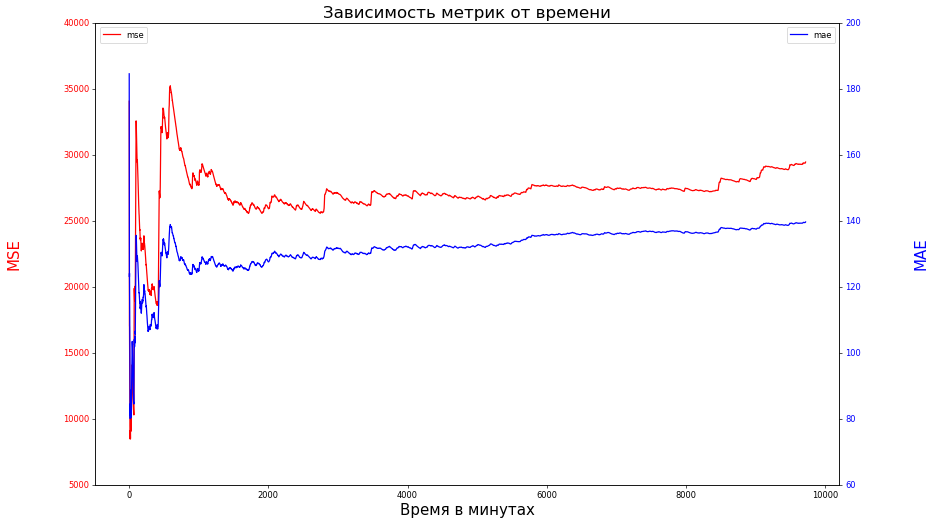

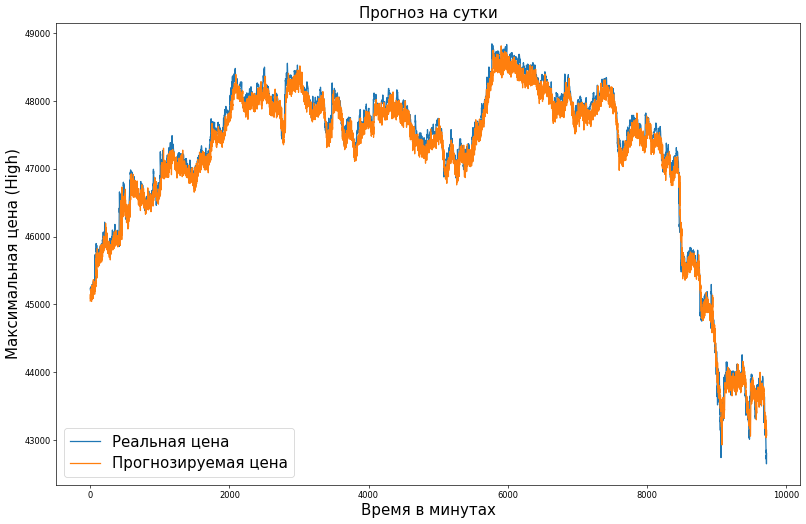

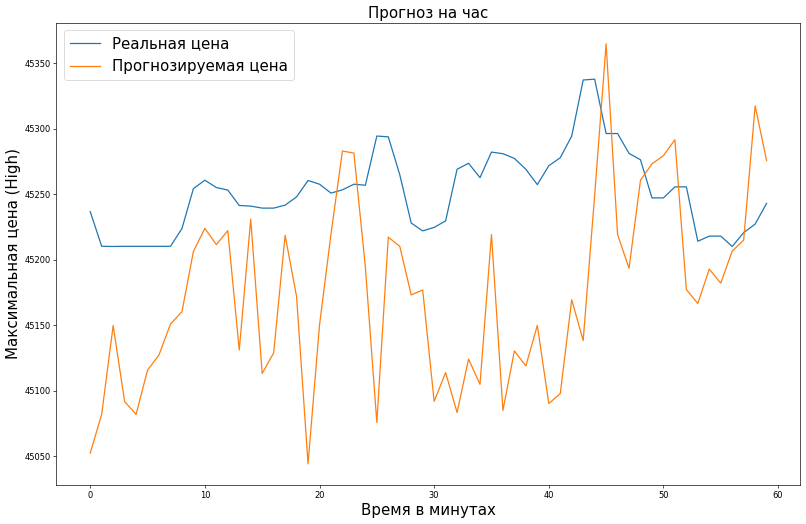

In [72]:
pred = cnn_model.predict(X_test)[:,2]
actual = y_scaler.inverse_transform(y_test).flatten()
pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

# pred = predict_invers_transform(X_test[-1600:], y_test[-1601:-1], gru_model)
val_to_time(actual, pred)
plot_forecast_val(actual, pred)

Epoch 1/5
389/389 [==============================] - ETA: 0s - loss: 0.0092
Epoch 1: val_loss improved from inf to 0.00078, saving model to cnn_model_checkpoint.h5
389/389 [==============================] - 9s 16ms/step - loss: 0.0092 - val_loss: 7.8011e-04
Epoch 2/5
387/389 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 2: val_loss improved from 0.00078 to 0.00049, saving model to cnn_model_checkpoint.h5
389/389 [==============================] - 5s 13ms/step - loss: 0.0018 - val_loss: 4.8656e-04
Epoch 3/5
388/389 [============================>.] - ETA: 0s - loss: 0.0013
Epoch 3: val_loss did not improve from 0.00049
389/389 [==============================] - 5s 13ms/step - loss: 0.0013 - val_loss: 5.0617e-04
Epoch 4/5
385/389 [============================>.] - ETA: 0s - loss: 0.0011
Epoch 4: val_loss did not improve from 0.00049
389/389 [==============================] - 5s 13ms/step - loss: 0.0011 - val_loss: 5.2242e-04
Epoch 5/5
388/389 [===========================

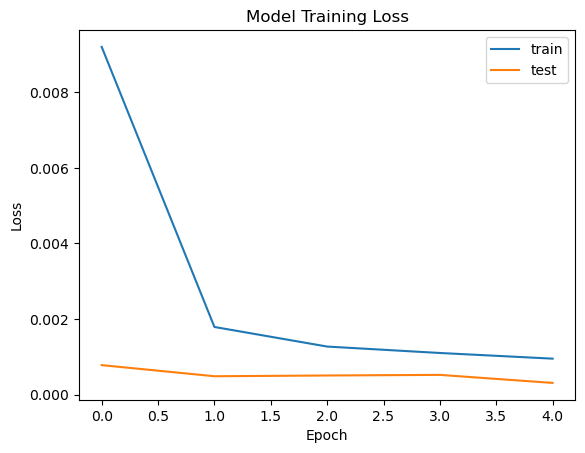

In [73]:
# cnn

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Flatten, LeakyReLU, Bidirectional
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard,ReduceLROnPlateau,ModelCheckpoint

cnn_neurons = 84
output_size = 1
epochs = 5 
batch_size = 20
dropout = 0.1
loss = 'mse'
optimizer = 'adam'
activ_func = "linear"

def build_cnn_model(input_data, output_size, neurons, activ_func=activ_func,
                      dropout=dropout, loss=loss, optimizer=optimizer):

    cnn_model = Sequential()
    cnn_model.add(Conv1D(neurons, kernel_size=1, activation=activ_func, input_shape=(input_data.shape[1], input_data.shape[2])))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    cnn_model.add(Dropout(0.1))
    cnn_model.add(Dropout(0.1))
    cnn_model.add(Dense(output_size, activation=activ_func))
    cnn_model.compile(loss=loss, optimizer=optimizer)
    return cnn_model

cnn_model = build_cnn_model(X_train, 
                         output_size=output_size, 
                         neurons=cnn_neurons, 
                         dropout=dropout, 
                         loss=loss,
                         optimizer=optimizer)

checkpoint_path = "cnn_model_checkpoint.h5"
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)


history = cnn_model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    shuffle=False,
                    use_multiprocessing=True,
                    callbacks=[checkpoint,  early_stopping])



plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [74]:
pred = cnn_model.predict(X_test)[:,2]
actual = y_scaler.inverse_transform(y_test).flatten()
pred = y_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

# pred = predict_invers_transform(X_test[-1600:], y_test[-1601:-1], gru_model)
val_to_time(actual, pred)
plot_forecast_val(actual, pred)

304/304 [==============================] - 2s 5ms/step


IndexError: index 2 is out of bounds for axis 1 with size 1

In [90]:
df_res['feature'][-10:].values

array(['20 period ZLEMA', '20 period EVWMA.', 'BB_UPPER', 'r4', 'high',
       'r2', '20 period WMA.', 'UPPER', '20 period KAMA.', 'TP'],
      dtype=object)

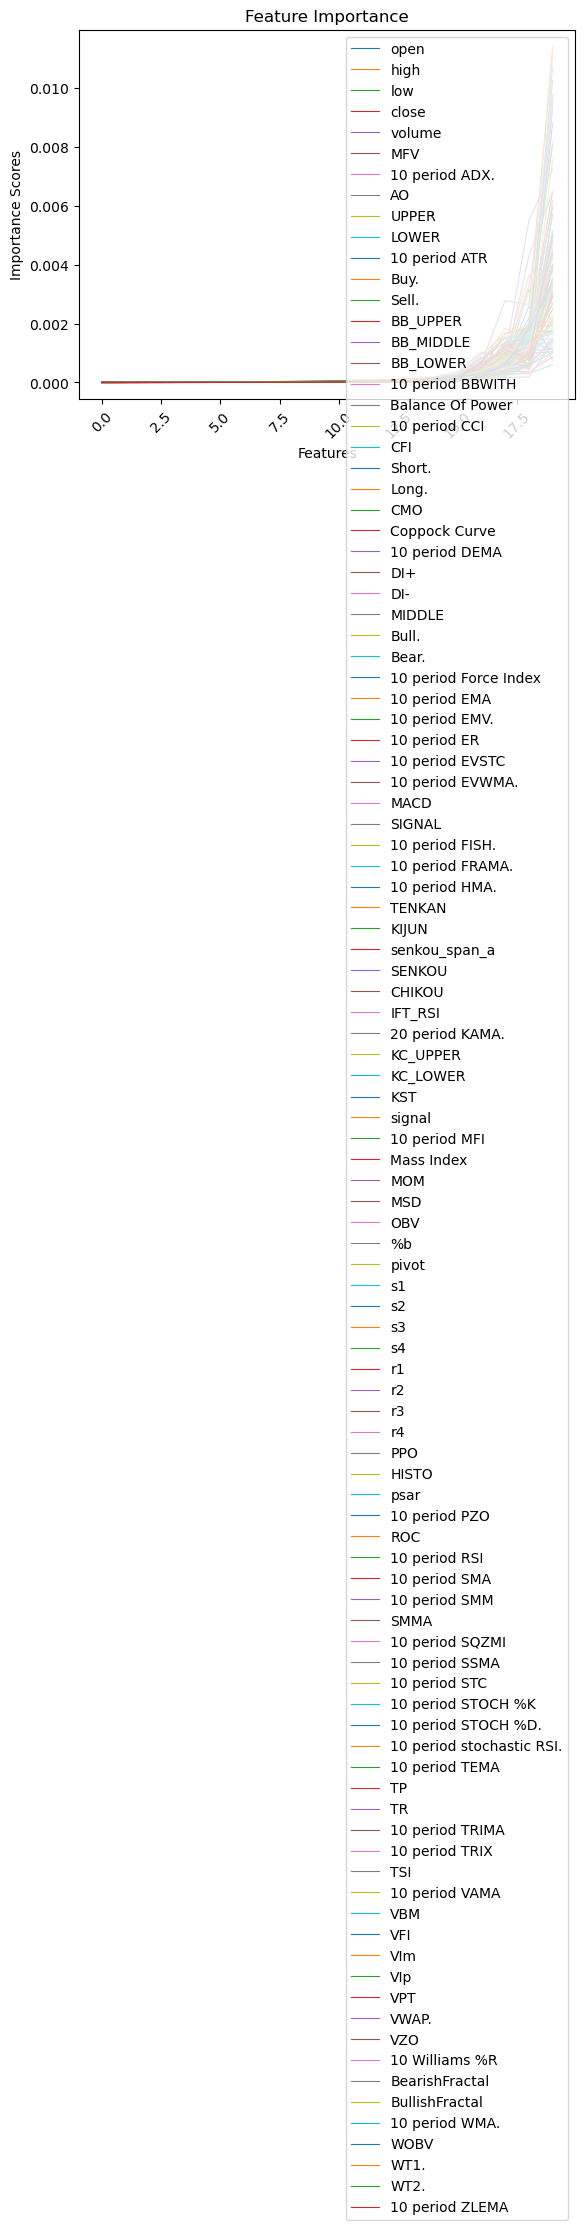

In [1006]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

# Получение градиентов входных признаков
def get_input_gradients(model, x):
    x_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor)
    gradients = tape.gradient(predictions, x_tensor)
    return gradients.numpy()

# Оценка важности признаков
def feature_importance(model, x):
    gradients = get_input_gradients(model, x)
    importance = np.std(abs(gradients), axis=0)
    return importance

# Оценка важности признаков для модели LAST
importance_scores = feature_importance(model, X_train)

feature_names = df.columns

# Визуализация важности признаков
feature_names = df.columns  # Замените на реальные названия признаков
for i,j in enumerate(feature_names):
    plt.plot(range(len(importance_scores.T[i])), importance_scores.T[i], linewidth=0.8, label=feature_names[i])  # Указываем ширину линии
plt.xticks(rotation=45)
plt.legend()  # Добавляем легенду с названиями линий
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

In [159]:
!pip3 install –upgrade mxnet~=1.7 gluonts

Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '–upgrade'


# DeepAR 

In [226]:
df = create_data(data, size=0.9999).drop('timestamp', axis = 1)
df

,Open,High,Low,Close,Volume
timestamp,,,,,
2021-09-20 23:45:00,43419.832500,43467.000000,43351.15,43375.040000,76.018320
2021-09-20 23:46:00,43368.716250,43405.000000,43280.00,43391.277500,83.812819
2021-09-20 23:47:00,43393.847143,43407.700000,43284.12,43328.331429,74.327602
2021-09-20 23:48:00,43329.654286,43350.000000,43283.74,43333.292857,54.749466
2021-09-20 23:49:00,43335.714325,43344.990000,43240.01,43272.205714,97.303259
...,...,...,...,...,...
2021-09-21 02:56:00,42983.780000,43001.850849,42878.26,42899.012857,56.850913
2021-09-21 02:57:00,42904.197143,42932.000000,42840.16,42860.005714,80.993326
2021-09-21 02:58:00,42859.385714,42887.500000,42797.20,42827.020000,65.677734


In [227]:
train, test = train_test_split(df, shuffle=False, train_size=0.8)